In [41]:
import numpy as np
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import SparsePauliOp
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from qiskit_ibm_runtime import Session
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_aer import AerSimulator

In [42]:
hamiltonian = SparsePauliOp.from_list([("XX",1), ("YY", 1), ("ZI", 1)])

Here, I've prepared the required hamiltonian

In [43]:
print(hamiltonian)

SparsePauliOp(['XX', 'YY', 'ZI'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j])


***

In [44]:
ansatz = EfficientSU2(hamiltonian.num_qubits, entanglement="linear", reps= 1)

Here, I've used the EfficientSU2 function to make a generalized ansatz using rotational gates and CNOT gates. As we can see below our circuit uses Ry and Rz gates along with a CNOT gate. In total we have 8 parameters (8 diffrent theta) which we can vary to minimize the eigenvalue and approch the ground state eigenfunction.

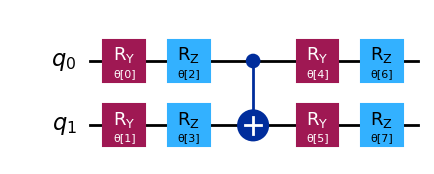

In [45]:
ansatz.decompose().draw("mpl", style="iqp")

In [46]:
print(ansatz.num_parameters)

8


***

In [47]:
cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

Here I have made a dictionary to keep track of our optimization process

In [48]:
def cost_func(params, ansatz, hamiltonian, estimator):
    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    energy = result[0].data.evs[0]

    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = params
    cost_history_dict["cost_history"].append(energy)
    print(f"Iters. done: {cost_history_dict['iters']} [Current cost: {energy}]")

    return energy

Above is our cost function the returns the expectation value of the trial wavefunction for our chosen hamiltonian.

***
Here I have initialized the 8 parameter values to random values

In [50]:
x0 = 2 * np.pi * np.random.random(ansatz.num_parameters)

In [51]:
x0

array([4.58200882, 3.08612862, 5.55252503, 1.60722265, 0.89141802,
       3.25516181, 1.3823014 , 3.88614992])

In [52]:
aer_sim = AerSimulator()

Below I have used the AER simulator as the backend for running the Estimator function that calculates the exceptation value of the hamiltonian for our trial wavefunction and act as the cost function for the QVE. For the classical optimizer I have used COBYLA.

In [54]:
with Session(backend=aer_sim) as session:
    estimator = Estimator(mode=session)
    #estimator = StatevectorEstimator()
    estimator.options.default_shots = 10000

    res = minimize(
        cost_func,
        x0,
        args=(ansatz.decompose(), hamiltonian, estimator),
        method="cobyla",
    )

Iters. done: 1 [Current cost: -0.1658]
Iters. done: 2 [Current cost: 0.7074]
Iters. done: 3 [Current cost: -0.02260000000000001]
Iters. done: 4 [Current cost: 0.10519999999999996]
Iters. done: 5 [Current cost: -0.14]
Iters. done: 6 [Current cost: -0.03240000000000001]
Iters. done: 7 [Current cost: -0.1488]
Iters. done: 8 [Current cost: -0.4338]
Iters. done: 9 [Current cost: -0.13599999999999995]
Iters. done: 10 [Current cost: -1.053]
Iters. done: 11 [Current cost: -0.9166000000000001]
Iters. done: 12 [Current cost: -0.9927999999999999]
Iters. done: 13 [Current cost: -1.0146000000000002]
Iters. done: 14 [Current cost: -1.0134]
Iters. done: 15 [Current cost: -1.087]
Iters. done: 16 [Current cost: -0.9508]
Iters. done: 17 [Current cost: -0.9288]
Iters. done: 18 [Current cost: -1.1543999999999999]
Iters. done: 19 [Current cost: -0.8798]
Iters. done: 20 [Current cost: -1.0806]
Iters. done: 21 [Current cost: -1.2964]
Iters. done: 22 [Current cost: -1.365]
Iters. done: 23 [Current cost: -1.28

In [57]:
print(res)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -2.1722
       x: [ 4.197e+00  2.560e+00  5.131e+00  1.462e+00  2.225e+00
            2.754e+00  2.870e+00  4.093e+00]
    nfev: 109
   maxcv: 0.0


As we can see we have succesfullly reached the minimum energy value through the iterative training in only 109 steps. This values is -2.17. This negative ground state energy clearly indicates that this hamiltonian doesn't represent a real quantum system.

***

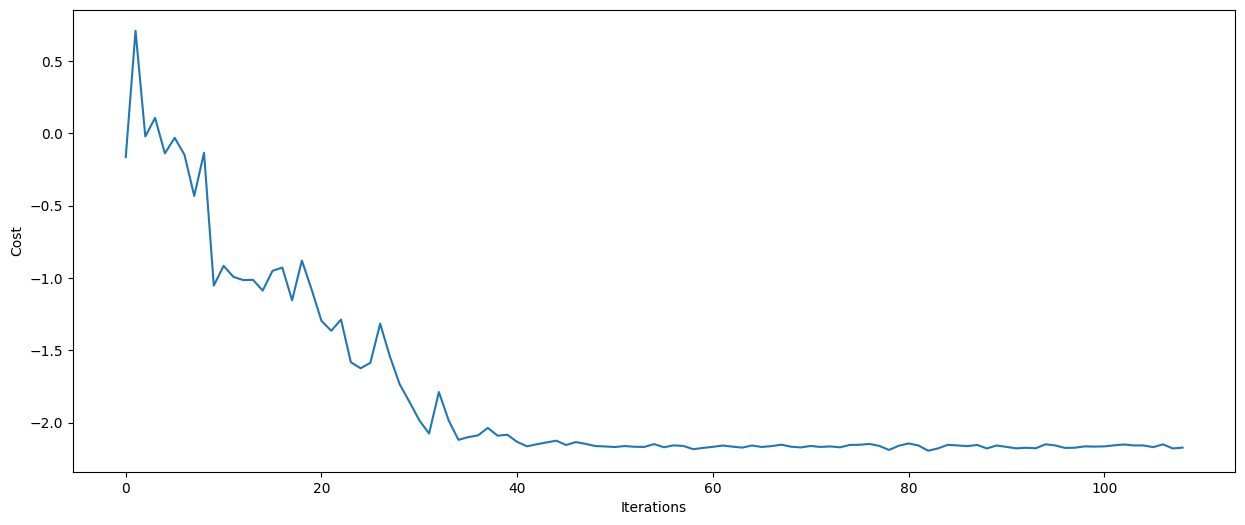

In [58]:
# Create a figure and axis with specific figure size (width, height)
fig, ax = plt.subplots(figsize=(15, 6))  # Adjust the width to 12 and height to 6

# Plot your data
ax.plot(range(cost_history_dict["iters"]), cost_history_dict["cost_history"])

# Set labels
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")

# Display the plot
plt.draw()

This represents the plot of the training process, as we can see the energy value rapidly decreases and eventually reaches a steady value of around -2.17
***

In [59]:
from qiskit_algorithms import NumPyMinimumEigensolver
solver = NumPyMinimumEigensolver()
result = solver. compute_minimum_eigenvalue(hamiltonian)

In [60]:
print(result)

{   'aux_operators_evaluated': None,
    'eigenstate': Statevector([ 0.00000000e+00+2.71050543e-18j,
              4.66298783e-01+2.42814018e-01j,
             -7.54487279e-01-3.92881335e-01j,
              7.77156117e-16-1.11022302e-16j],
            dims=(2, 2)),
    'eigenvalue': np.float64(-2.236067977499788)}


Here, I have calculated the actual value of the ground state energy of the given hamiltonian using NumPyMinimumEigensolver and it comes out to be -2.23 which is very close to our ground state energy values which we obtained using QVE. The minor discrepeancy can be removed by using better ansatz as the final value depends a lot on how well is the chosen ansatz. Also we can try to use a different classical optimizer to make sure that we converge at the global minima for that ansatz.